In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
cx_feedback = pd.read_csv("Customer_Feedback_Data.csv")
# Check the dataset structure
print(cx_feedback.head())
print(cx_feedback.info())

   Customer_ID  Satisfaction_Score  Feedback_Comments  Likelihood_to_Recommend
0            1                10.0     Very satisfied                        9
1            2                 3.0     Very satisfied                        3
2            3                10.0     Very satisfied                        1
3            4                 7.0  Needs improvement                        4
4            5                 8.0     Unsatisfactory                        7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer_ID              5050 non-null   int64  
 1   Satisfaction_Score       4949 non-null   float64
 2   Feedback_Comments        5050 non-null   object 
 3   Likelihood_to_Recommend  5050 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 157.9+ KB
None


In [3]:
# Find and remove duplicate rows
duplicates = cx_feedback[cx_feedback.duplicated()]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

cx_feedback_before = cx_feedback.shape
cx_feedback = cx_feedback.drop_duplicates()
cx_feedback_after = cx_feedback.shape

print(f"Shape before removing duplicates: {cx_feedback_before}")
print(f"Shape after removing duplicates: {cx_feedback_after}")

Number of duplicate rows: 81
Shape before removing duplicates: (5050, 4)
Shape after removing duplicates: (4969, 4)


In [5]:
# Handle missing values
missing_values = cx_feedback.isnull().sum()
print("Missing values in each column:\n", missing_values)
cx_feedback['Satisfaction_Score'] = cx_feedback['Satisfaction_Score'].fillna(cx_feedback['Satisfaction_Score'].median())

Missing values in each column:
 Customer_ID                  0
Satisfaction_Score         100
Feedback_Comments            0
Likelihood_to_Recommend      0
dtype: int64


In [7]:
# Convert categorical features to numerical
cx_feedback['Feedback_Comments'] = cx_feedback['Feedback_Comments'].astype('category')
cx_feedback['Feedback_Comments_Encoded'] = cx_feedback['Feedback_Comments'].cat.codes
print("Original and Encoded Feedback_Comments:\n", cx_feedback[['Feedback_Comments', 'Feedback_Comments_Encoded']].head())

Original and Encoded Feedback_Comments:
    Feedback_Comments  Feedback_Comments_Encoded
0     Very satisfied                          4
1     Very satisfied                          4
2     Very satisfied                          4
3  Needs improvement                          2
4     Unsatisfactory                          3


In [9]:
# Calculate skewness for numeric columns
skewness = cx_feedback[['Satisfaction_Score', 'Likelihood_to_Recommend']].skew()

# Display skewness
print(skewness)

Satisfaction_Score         5.356323
Likelihood_to_Recommend   -0.017615
dtype: float64


In [11]:
# Calculate IQR for Satisfaction_Score
Q1 = cx_feedback['Satisfaction_Score'].quantile(0.25)
Q3 = cx_feedback['Satisfaction_Score'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Impute outliers for Satisfaction_Score with median
cx_feedback['Satisfaction_Score'] = cx_feedback['Satisfaction_Score'].apply(lambda x: cx_feedback['Satisfaction_Score'].median() if x < lower_bound or x > upper_bound else x)

# Calculate IQR for Likelihood_to_Recommend
Q1 = cx_feedback['Likelihood_to_Recommend'].quantile(0.25)
Q3 = cx_feedback['Likelihood_to_Recommend'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Impute outliers for Likelihood_to_Recommend with mean
cx_feedback['Likelihood_to_Recommend'] = cx_feedback['Likelihood_to_Recommend'].apply(lambda x: cx_feedback['Likelihood_to_Recommend'].mean() if x < lower_bound or x > upper_bound else x)

# Check Satisfaction_Score for outliers
satisfaction_outliers = cx_feedback[(cx_feedback['Satisfaction_Score'] < lower_bound) | (cx_feedback['Satisfaction_Score'] > upper_bound)]
print(f"Number of outliers in Satisfaction_Score: {satisfaction_outliers.shape[0]}")

# Check Likelihood_to_Recommend for outliers
recommendation_outliers = cx_feedback[(cx_feedback['Likelihood_to_Recommend'] < lower_bound) | (cx_feedback['Likelihood_to_Recommend'] > upper_bound)]
print(f"Number of outliers in Likelihood_to_Recommend: {recommendation_outliers.shape[0]}")

# Clean Satisfaction_Score and Feedback_Comments using updated rules
def clean_feedback(score):
    if score >= 10:
        return "Excellent"
    elif 8 <= score < 10:
        return "Very satisfied"
    elif 5 <= score < 8:
        return "Good service"
    elif 3 <= score < 5:
        return "Needs improvement"
    elif score < 3:
        return "Unsatisfactory"
    return None

# Apply the cleaning function
cx_feedback['Feedback_Comment'] = cx_feedback['Satisfaction_Score'].apply(clean_feedback)

# Normalize Satisfaction_Score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cx_feedback['Satisfaction_Score_Normalized'] = scaler.fit_transform(cx_feedback[['Satisfaction_Score']])

# Normalize Likelihood_to_Recommend
cx_feedback['Likelihood_to_Recommend_Normalized'] = scaler.fit_transform(cx_feedback[['Likelihood_to_Recommend']])

# Final confirmation
if satisfaction_outliers.empty and recommendation_outliers.empty:
    print("No outliers remain in Satisfaction_Score and Likelihood_to_Recommend.")
else:
    print("Some outliers still exist in the data.")

Number of outliers in Satisfaction_Score: 0
Number of outliers in Likelihood_to_Recommend: 0
No outliers remain in Satisfaction_Score and Likelihood_to_Recommend.


In [13]:
# Remove the original Feedback_Comments column
if 'Feedback_Comments' in cx_feedback.columns:
    cx_feedback.drop(columns=['Feedback_Comments'], inplace=True)

print (cx_feedback)

      Customer_ID  Satisfaction_Score  Likelihood_to_Recommend  \
0               1                10.0                        9   
1               2                 3.0                        3   
2               3                10.0                        1   
3               4                 7.0                        4   
4               5                 8.0                        7   
...           ...                 ...                      ...   
4995          169                 4.0                        3   
4996          520                 7.0                        5   
4997          963                 1.0                        4   
4998          926                 9.0                        1   
4999          598                10.0                       10   

      Feedback_Comments_Encoded   Feedback_Comment  \
0                             4          Excellent   
1                             4  Needs improvement   
2                             4          Exce

In [15]:
# Categorize Likelihood_to_Recommend without overwriting original values
cx_feedback['Recommendation_Category'] = pd.cut(
    cx_feedback['Likelihood_to_Recommend'], 
    bins=[0, 4, 7, 10], 
    labels=['Low', 'Medium', 'High'], 
    right=True
)

# Categorize Satisfaction_Score
cx_feedback['Satisfaction_Category'] = pd.cut(
    cx_feedback['Satisfaction_Score'], 
    bins=[0, 3, 6, 10], 
    labels=['Dissatisfied', 'Neutral', 'Satisfied'], 
    right=True
)

# Display the updated dataset for the first 5 customers
cx_feedback.head (5)

,Customer_ID,Satisfaction_Score,Likelihood_to_Recommend,Feedback_Comments_Encoded,Feedback_Comment,Satisfaction_Score_Normalized,Likelihood_to_Recommend_Normalized,Recommendation_Category,Satisfaction_Category
0,1,10.0,9,4,Excellent,1.000000,0.888889,High,Satisfied
1,2,3.0,3,4,Needs improvement,0.222222,0.222222,Low,Dissatisfied
2,3,10.0,1,4,Excellent,1.000000,0.000000,Low,Satisfied
3,4,7.0,4,2,Good service,0.666667,0.333333,Low,Satisfied
4,5,8.0,7,3,Very satisfied,0.777778,0.666667,Medium,Satisfied


In [17]:
# Summary of the dataset
print("Dataset Summary:\n", cx_feedback.describe())
print("\nUnique values per column:\n", cx_feedback.nunique())

Dataset Summary:
        Customer_ID  Satisfaction_Score  Likelihood_to_Recommend  \
count  4969.000000         4969.000000              4969.000000   
mean    501.988126            5.600121                 5.569732   
std     288.781086            2.799185                 2.867726   
min       1.000000            1.000000                 1.000000   
25%     254.000000            3.000000                 3.000000   
50%     502.000000            6.000000                 6.000000   
75%     752.000000            8.000000                 8.000000   
max    1000.000000           10.000000                10.000000   

       Feedback_Comments_Encoded  Satisfaction_Score_Normalized  \
count                4969.000000                    4969.000000   
mean                    2.106058                       0.511125   
std                     1.295283                       0.311021   
min                     0.000000                       0.000000   
25%                     1.000000           

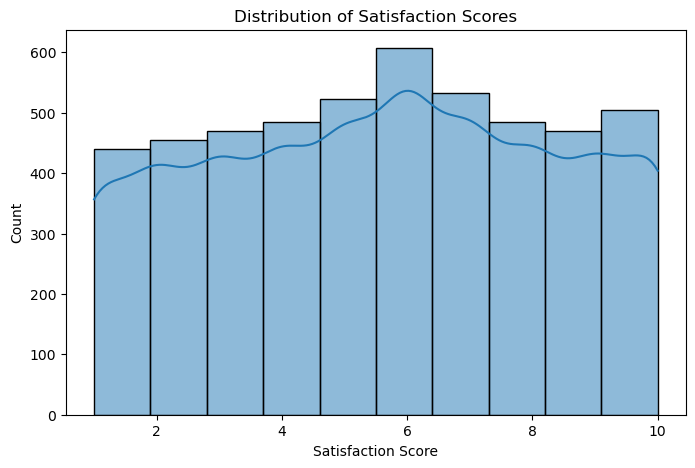

In [19]:
# **Distribution of Satisfaction Scores**
# This histogram helps us analyze the spread of customer satisfaction scores.
# - If most scores cluster around higher values (e.g., 8-10), it suggests that customers are generally satisfied.
# - If the scores are evenly spread or lean toward the lower end (1-3), it indicates significant dissatisfaction.
# - The shape of the distribution can reveal trends: 
#   - A right-skewed distribution (scores mostly low) signals customer dissatisfaction.
#   - A left-skewed distribution (scores mostly high) suggests strong customer approval.
# This visualization helps in identifying overall customer sentiment trends.

plt.figure(figsize=(8, 5))
sns.histplot(cx_feedback['Satisfaction_Score'], bins=10, kde=True)
plt.title("Distribution of Satisfaction Scores")
plt.xlabel("Satisfaction Score")
plt.ylabel("Count")
plt.show()

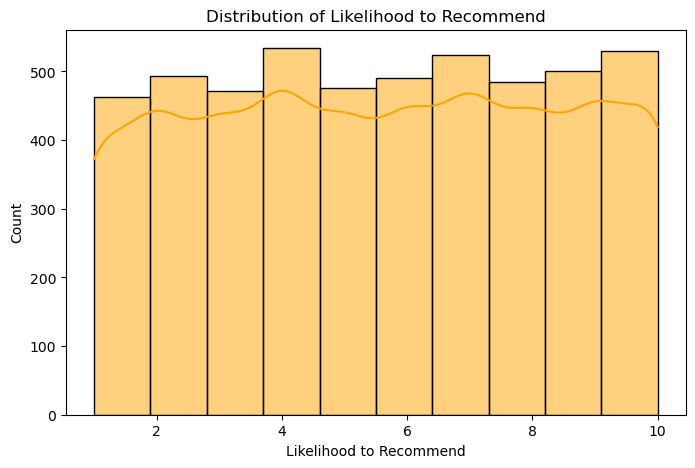

In [21]:
# **Distribution of Likelihood to Recommend**
# This histogram visualizes how likely customers are to recommend the service.
# - A peak in the higher range (8-10) suggests that most customers are promoters.
# - A peak in the middle range (5-7) indicates passive customers, who are neutral.
# - If lower scores dominate (1-4), many customers are detractors, signaling dissatisfaction.
# This visualization helps in assessing brand loyalty and advocacy.


plt.figure(figsize=(8, 5))
sns.histplot(cx_feedback['Likelihood_to_Recommend'], bins=10, kde=True, color='orange')
plt.title("Distribution of Likelihood to Recommend")
plt.xlabel("Likelihood to Recommend")
plt.ylabel("Count")
plt.show()

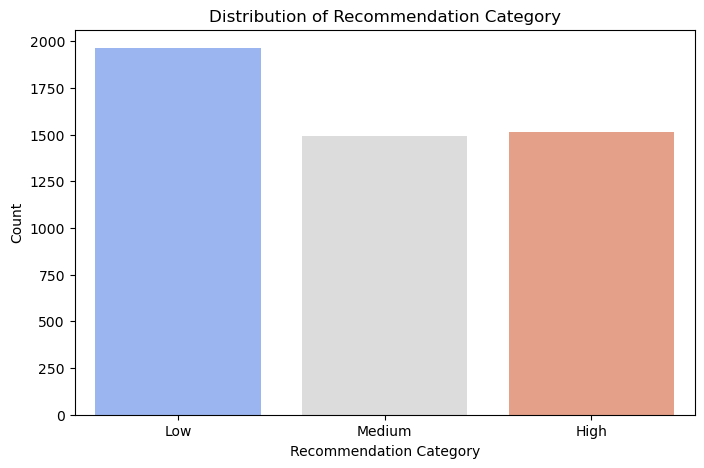

In [23]:
# **Distribution of Recommendation Category**
# This countplot categorizes customers into promoters, passives, and detractors.
# - Promoters (scores 9-10) indicate loyal customers who actively recommend the service.
# - Passives (scores 7-8) are neutral and might recommend under specific circumstances.
# - Detractors (scores 0-6) are dissatisfied customers who could discourage others.
# Identifying the proportion of each category helps in refining customer engagement strategies.

plt.figure(figsize=(8, 5))
sns.countplot(x='Recommendation_Category', data=cx_feedback, hue='Recommendation_Category', palette='coolwarm', legend=False)
plt.title("Distribution of Recommendation Category")
plt.xlabel("Recommendation Category")
plt.ylabel("Count")
plt.show()

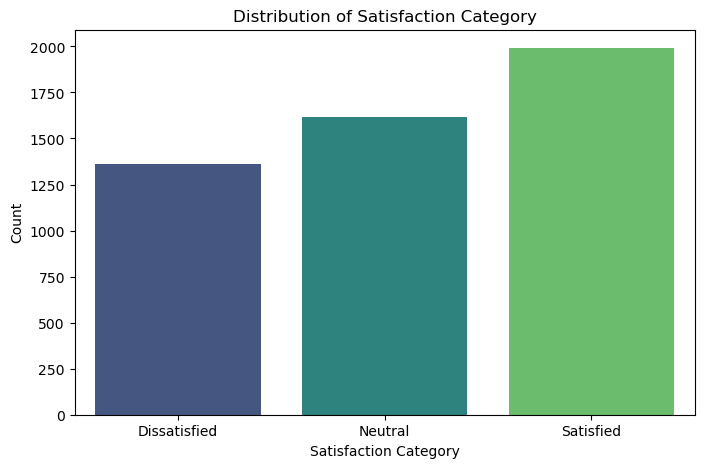

In [25]:
# **Distribution of Satisfaction Category**
# This plot shows the proportion of customers in different satisfaction categories.
# - A high number in "High Satisfaction" means customers are generally happy.
# - If a large portion of customers are in "Low Satisfaction," this indicates service issues.
# - A balance between these categories suggests a mix of satisfied and dissatisfied customers.
# This visualization helps in assessing overall service quality and improvement areas.

plt.figure(figsize=(8, 5))
sns.countplot(x='Satisfaction_Category', data=cx_feedback, hue='Satisfaction_Category', palette='viridis', legend=False)
plt.title("Distribution of Satisfaction Category")
plt.xlabel("Satisfaction Category")
plt.ylabel("Count")
plt.show()

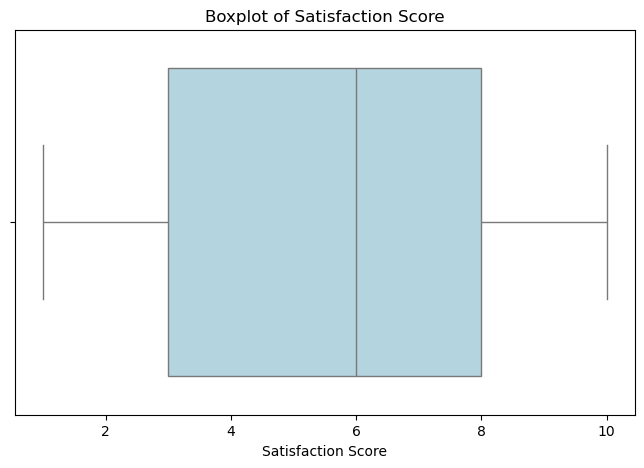

In [27]:
# **Boxplot of Satisfaction Score**
# A boxplot helps visualize the distribution of satisfaction scores.
# - The median line shows the central tendency of scores.
# - The interquartile range (IQR) highlights variability.
# - Outliers (dots outside the whiskers) indicate extreme cases of satisfaction or dissatisfaction.
# This is useful for identifying anomalies in customer feedback.

plt.figure(figsize=(8, 5))
sns.boxplot(x=cx_feedback['Satisfaction_Score'], color='lightblue')
plt.title("Boxplot of Satisfaction Score")
plt.xlabel("Satisfaction Score")
plt.show()

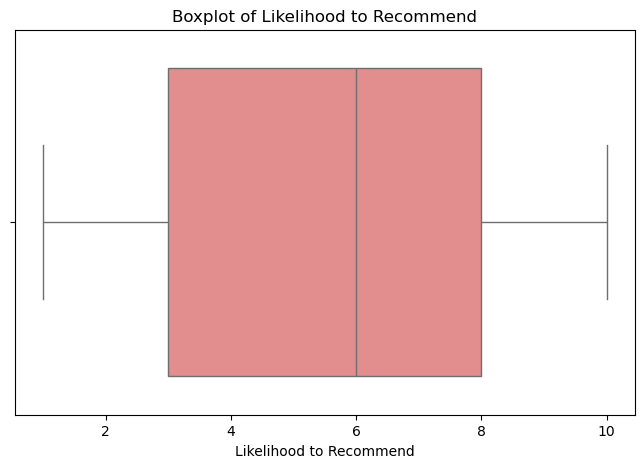

In [29]:
# **Boxplot of Likelihood to Recommend**
# This boxplot shows how likely customers are to recommend the service.
# - A high median suggests most customers are likely to recommend.
# - A wider IQR indicates variability in recommendations.
# - Outliers represent customers with extreme opinions (very satisfied or dissatisfied).
# Understanding this spread helps in gauging brand loyalty.

plt.figure(figsize=(8, 5))
sns.boxplot(x=cx_feedback['Likelihood_to_Recommend'], color='lightcoral')
plt.title("Boxplot of Likelihood to Recommend")
plt.xlabel("Likelihood to Recommend")
plt.show()

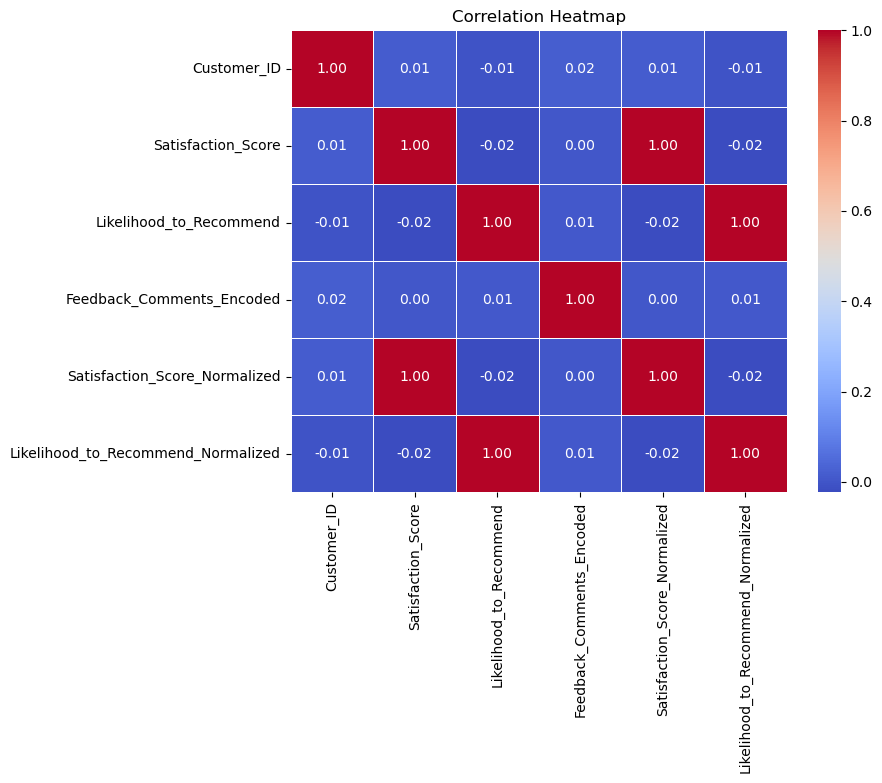

In [31]:
# **Correlation Heatmap**
# This heatmap shows relationships between numerical variables.
# - A strong correlation between 'Satisfaction_Score' and 'Likelihood_to_Recommend' suggests that
#   satisfied customers are more likely to recommend the service.
# - Weak correlations indicate that other factors influence recommendations.
# - This visualization helps in identifying key drivers of customer satisfaction and loyalty.

plt.figure(figsize=(8, 6))
sns.heatmap(cx_feedback.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [33]:
# Pearson Correlation
pearson_corr, pearson_p = pearsonr(cx_feedback['Satisfaction_Score'], cx_feedback['Likelihood_to_Recommend'])
print(f"Pearson Correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Spearman Correlation
spearman_corr, spearman_p = spearmanr(cx_feedback['Satisfaction_Score'], cx_feedback['Likelihood_to_Recommend'])
print(f"Spearman Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

# Summary statistics per Satisfaction Category
satisfaction_summary = cx_feedback.groupby("Satisfaction_Category", observed=True)["Satisfaction_Score"].agg(["count", "mean", "std"])
print("\nSatisfaction Category Summary:\n", satisfaction_summary)

# Summary statistics per Recommendation Category
recommendation_summary = cx_feedback.groupby("Recommendation_Category", observed=True)["Likelihood_to_Recommend"].agg(["count", "mean", "std"])
print("\nRecommendation Category Summary:\n", recommendation_summary)

Pearson Correlation: -0.0230, p-value: 0.1055
Spearman Correlation: -0.0240, p-value: 0.0901

Satisfaction Category Summary:
                        count      mean       std
Satisfaction_Category                           
Dissatisfied            1363  2.021277  0.816669
Neutral                 1615  5.075542  0.819066
Satisfied               1991  8.475640  1.136549

Recommendation Category Summary:
                          count      mean       std
Recommendation_Category                           
Low                       1963  2.548650  1.124308
Medium                    1491  6.032193  0.818599
High                      1515  9.029043  0.817866


In [35]:
# Load the product offering dataset
prod_off = pd.read_csv("Product_Offering_Data.csv")

# Check dataset structure
print(prod_off.info())
print(prod_off.head())
prod_off.drop(columns=['Target_Age_Group'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Product_ID           15 non-null     int64  
 1   Product_Name         15 non-null     object 
 2   Product_Type         15 non-null     object 
 3   Risk_Level           15 non-null     object 
 4   Target_Age_Group     0 non-null      float64
 5   Target_Income_Group  15 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 852.0+ bytes
None
   Product_ID                   Product_Name     Product_Type Risk_Level  \
0           1           Platinum Credit Card      Credit Card     Medium   
1           2           Gold Savings Account  Savings Account        Low   
2           3  High-Yield Investment Account       Investment       High   
3           4                  Mortgage Loan             Loan     Medium   
4           5                      Auto Loan  

In [37]:
# Remove duplicate rows
prod_off = prod_off.drop_duplicates()

# Check for missing values
print("Missing values before handling:\n", prod_off.isnull().sum())

Missing values before handling:
 Product_ID             0
Product_Name           0
Product_Type           0
Risk_Level             0
Target_Income_Group    0
dtype: int64


In [39]:
# One-hot encode categorical variables
categorical_columns = ['Product_Type', 'Risk_Level', 'Target_Income_Group']
# Convert categorical variables into numerical form using one-hot encoding
# Converting categorical variables into numerical format using one-hot encoding.
# This ensures machine learning models can interpret categorical data effectively.
prod_off = pd.get_dummies(prod_off, columns=categorical_columns, drop_first=True)
print (prod_off)

   Product_ID                   Product_Name  Product_Type_Investment  \
0           1           Platinum Credit Card                    False   
1           2           Gold Savings Account                    False   
2           3  High-Yield Investment Account                     True   
3           4                  Mortgage Loan                    False   
4           5                      Auto Loan                    False   
5           6                  Personal Loan                    False   
6           7          Youth Savings Account                    False   
7           8     Retirement Investment Fund                     True   
8           9                  Business Loan                    False   
9          10             Travel Credit Card                    False   

   Product_Type_Loan  Product_Type_Savings Account  Risk_Level_Low  \
0              False                         False           False   
1              False                          True      

In [43]:
# Create Product_Category
prod_off['Product_Category'] = prod_off[[col for col in prod_off.columns if col.startswith("Product_Type_")]].idxmax(axis=1)
prod_off['Product_Category'] = prod_off['Product_Category'].str.replace('Product_Type_', '')
prod_off. head (20)

,Product_ID,Product_Name,Product_Type_Investment,Product_Type_Loan,Product_Type_Savings Account,Risk_Level_Low,Risk_Level_Medium,Target_Income_Group_Low,Target_Income_Group_Medium,Target_Age_Group,Product_Category
0,1,Platinum Credit Card,False,False,False,False,True,False,True,40.53,Investment
1,2,Gold Savings Account,False,False,True,True,False,True,False,25.41,Savings Account
2,3,High-Yield Investment Account,True,False,False,False,False,False,False,56.52,Investment
3,4,Mortgage Loan,False,True,False,False,True,False,False,41.34,Loan
4,5,Auto Loan,False,True,False,False,True,False,True,42.36,Loan
5,6,Personal Loan,False,True,False,False,True,True,False,35.03,Loan
6,7,Youth Savings Account,False,False,True,True,False,True,False,27.10,Savings Account
7,8,Retirement Investment Fund,True,False,False,False,False,False,False,54.32,Investment
8,9,Business Loan,False,True,False,False,True,False,True,36.47,Loan
9,10,Travel Credit Card,False,False,False,False,True,False,True,49.86,Investment


In [45]:
# Feature Engineering
# Apply Min-Max Scaling to normalize numerical features between 0 and 1
# Applying Min-Max Scaling to normalize numerical values between 0 and 1.
# This ensures that models are not biased toward large-scale numerical values.
scaler = MinMaxScaler()
prod_off['Target_Age_Group_Scaled'] = scaler.fit_transform(prod_off[['Target_Age_Group']])
prod_off['Total_Product_Types'] = prod_off[['Product_Type_Investment', 'Product_Type_Loan', 'Product_Type_Savings Account']].sum(axis=1)
prod_off['Risk_to_Product_Ratio'] = (prod_off['Risk_Level_Medium'] + (prod_off['Risk_Level_Low'] == 0)) / (prod_off['Total_Product_Types'] + 1)
prod_off['Savings_vs_Loan_Ratio'] = prod_off['Product_Type_Savings Account'] / (prod_off['Product_Type_Loan'] + 1)

def categorize_risk(row):
    if row['Risk_Level_Low'] == 1:
        return 'Low Risk'
    elif row['Risk_Level_Medium'] == 1:
        return 'Medium Risk'
    else:
        return 'High Risk'

prod_off['Risk_Category'] = prod_off.apply(categorize_risk, axis=1)
prod_off. head (20)

,Product_ID,Product_Name,Product_Type_Investment,Product_Type_Loan,Product_Type_Savings Account,Risk_Level_Low,Risk_Level_Medium,Target_Income_Group_Low,Target_Income_Group_Medium,Target_Age_Group,Product_Category,Target_Age_Group_Scaled,Total_Product_Types,Risk_to_Product_Ratio,Savings_vs_Loan_Ratio,Risk_Category
0,1,Platinum Credit Card,False,False,False,False,True,False,True,40.53,Investment,0.486017,0,1.0,0.0,Medium Risk
1,2,Gold Savings Account,False,False,True,True,False,True,False,25.41,Savings Account,0.000000,1,0.0,1.0,Low Risk
2,3,High-Yield Investment Account,True,False,False,False,False,False,False,56.52,Investment,1.000000,1,0.5,0.0,High Risk
3,4,Mortgage Loan,False,True,False,False,True,False,False,41.34,Loan,0.512054,1,0.5,0.0,Medium Risk
4,5,Auto Loan,False,True,False,False,True,False,True,42.36,Loan,0.544841,1,0.5,0.0,Medium Risk
5,6,Personal Loan,False,True,False,False,True,True,False,35.03,Loan,0.309225,1,0.5,0.0,Medium Risk
6,7,Youth Savings Account,False,False,True,True,False,True,False,27.10,Savings Account,0.054323,1,0.0,1.0,Low Risk
7,8,Retirement Investment Fund,True,False,False,False,False,False,False,54.32,Investment,0.929283,1,0.5,0.0,High Risk
8,9,Business Loan,False,True,False,False,True,False,True,36.47,Loan,0.355513,1,0.5,0.0,Medium Risk
9,10,Travel Credit Card,False,False,False,False,True,False,True,49.86,Investment,0.785921,0,1.0,0.0,Medium Risk


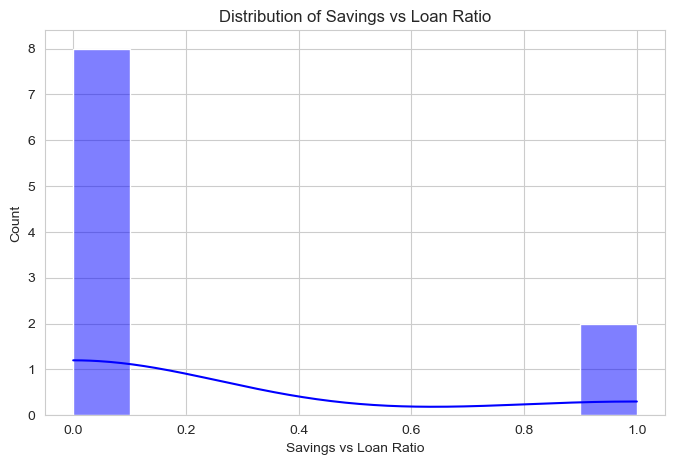

In [47]:
# EDA Visualizations
sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))
# Plot a histogram to visualize the distribution of a numerical feature
# Plotting a histogram to analyze the distribution of a particular feature.
# Helps to understand skewness and outlier presence in numerical data.
sns.histplot(prod_off['Savings_vs_Loan_Ratio'], bins=10, kde=True, color='blue')
plt.title("Distribution of Savings vs Loan Ratio")
plt.xlabel("Savings vs Loan Ratio")
plt.ylabel("Count")
plt.show()

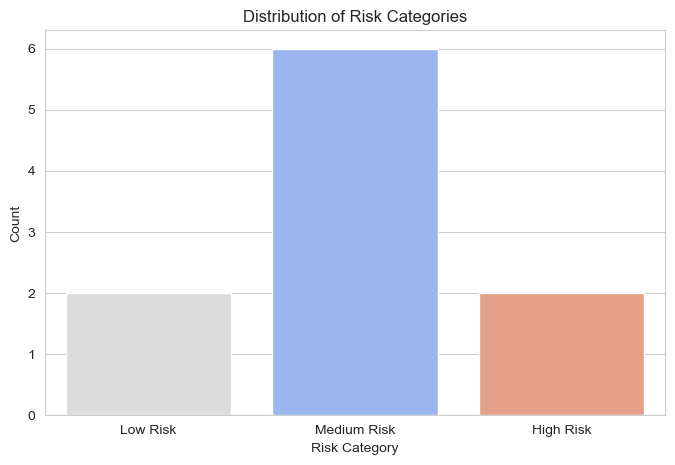

In [49]:
plt.figure(figsize=(8, 5))
# Generate a bar chart to display counts of categorical variables
# Visualizing categorical data distribution using a count plot.
# This helps determine the most and least common product types.
sns.countplot(x='Risk_Category', data=prod_off, hue='Risk_Category', palette='coolwarm', order=['Low Risk', 'Medium Risk', 'High Risk'], legend=False)
plt.title("Distribution of Risk Categories")
plt.xlabel("Risk Category")
plt.ylabel("Count")
plt.show()

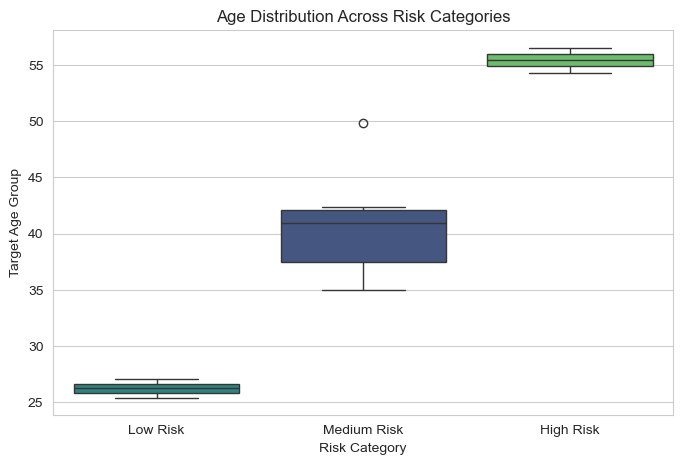

In [51]:
plt.figure(figsize=(8, 5))
# Create a box plot to observe outliers and spread of numerical values across categories
# Generating a box plot to detect outliers and assess the spread of numerical values.
# Useful in identifying extreme values that may impact analysis.
sns.boxplot(x='Risk_Category', y='Target_Age_Group', data=prod_off, hue='Risk_Category', palette='viridis', order=['Low Risk', 'Medium Risk', 'High Risk'], legend=False)
plt.title("Age Distribution Across Risk Categories")
plt.xlabel("Risk Category")
plt.ylabel("Target Age Group")
plt.show()

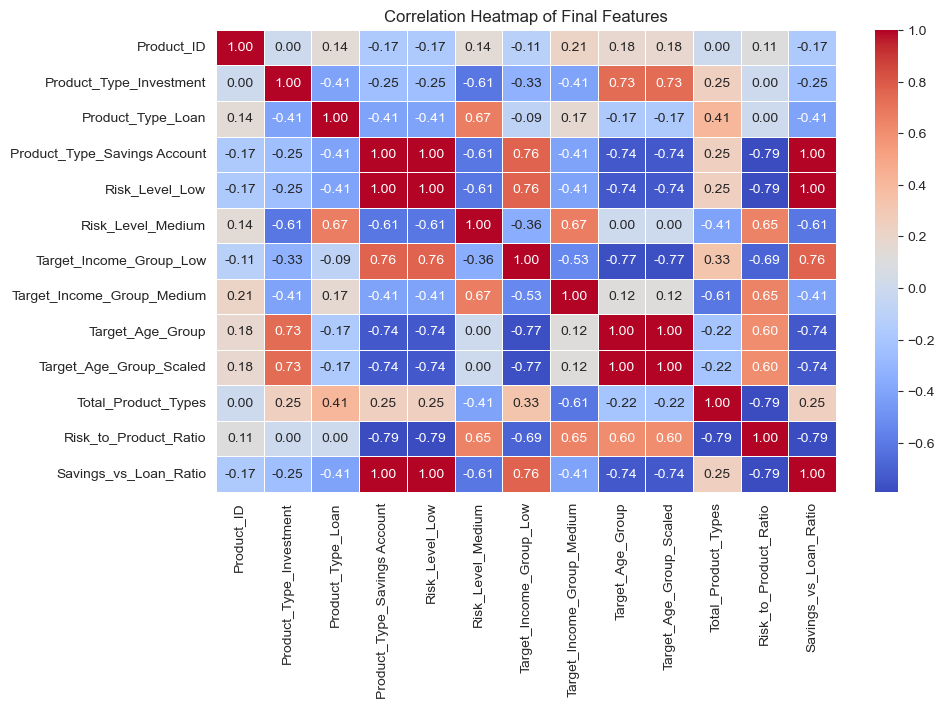

In [53]:
plt.figure(figsize=(10, 6))
# Generate a heatmap to visualize correlations between numerical features
# Creating a correlation heatmap to visualize relationships between numerical variables.
# This helps in understanding which features may impact product offerings the most.
sns.heatmap(prod_off.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Final Features")
plt.show()

In [55]:
# Load the transactions dataset
transact = pd.read_csv("Transaction_Data.csv")
# Check the dataset structure
print(transact.head())
print(transact.info())

   Transaction_ID  Customer_ID     Transaction_Date  Transaction_Amount  \
0               1          393  2023-01-01 00:00:00              3472.0   
1               2          826  2023-01-01 01:00:00                 NaN   
2               3          916  2023-01-01 02:00:00                10.0   
3               4          109  2023-01-01 03:00:00                72.0   
4               5          889  2023-01-01 04:00:00              1793.0   

  Transaction_Type  
0         Purchase  
1     Bill Payment  
2         Purchase  
3       Investment  
4       Investment  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction_ID      5050 non-null   int64  
 1   Customer_ID         5050 non-null   int64  
 2   Transaction_Date    5050 non-null   object 
 3   Transaction_Amount  4950 non-null   float64
 4   Transaction_Type  

In [57]:
# Find and remove duplicate rows
duplicates = transact[transact.duplicated()]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

transact_before = transact.shape
transact = transact.drop_duplicates()
transact_after = transact.shape

print(f"Shape before removing duplicates: {transact_before}")
print(f"Shape after removing duplicates: {transact_after}")

Number of duplicate rows: 50
Shape before removing duplicates: (5050, 5)
Shape after removing duplicates: (5000, 5)


In [59]:
# Handle missing values
missing_values = transact.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Transaction_ID          0
Customer_ID             0
Transaction_Date        0
Transaction_Amount    100
Transaction_Type        0
dtype: int64


In [61]:
for column in transact.select_dtypes(include=['float64', 'int64']).columns:
    if column == 'Transaction_Amount':  
        mean_value = round(transact[column].mean(), 2)
        transact[column] = transact[column].fillna(mean_value)
    else:
        transact[column] = transact[column].fillna(transact[column].mean())

print (transact)

      Transaction_ID  Customer_ID     Transaction_Date  Transaction_Amount  \
0                  1          393  2023-01-01 00:00:00             3472.00   
1                  2          826  2023-01-01 01:00:00             3102.05   
2                  3          916  2023-01-01 02:00:00               10.00   
3                  4          109  2023-01-01 03:00:00               72.00   
4                  5          889  2023-01-01 04:00:00             1793.00   
...              ...          ...                  ...                 ...   
4995            4996          175  2023-07-28 03:00:00             2755.00   
4996            4997          338  2023-07-28 04:00:00             3555.00   
4997            4998          694  2023-07-28 05:00:00             3003.00   
4998            4999          940  2023-07-28 06:00:00              790.00   
4999            5000          353  2023-07-28 07:00:00              955.00   

     Transaction_Type  
0            Purchase  
1        Bill P

In [63]:
# Confirm no missing values remain
missing_values_after = transact.isnull().sum()
print("Missing values after imputation:\n", missing_values_after)

Missing values after imputation:
 Transaction_ID        0
Customer_ID           0
Transaction_Date      0
Transaction_Amount    0
Transaction_Type      0
dtype: int64


In [65]:
# Perform one-hot encoding to convert Transaction_Type to numerical
transact_encoded = pd.get_dummies(transact, columns=['Transaction_Type'], prefix='Type', drop_first=False)

# Display the updated dataset structure again to confirm
transact_encoded.head()

,Transaction_ID,Customer_ID,Transaction_Date,Transaction_Amount,Type_Bill Payment,Type_Investment,Type_Loan Payment,Type_Purchase
0,1,393,2023-01-01 00:00:00,3472.00,False,False,False,True
1,2,826,2023-01-01 01:00:00,3102.05,True,False,False,False
2,3,916,2023-01-01 02:00:00,10.00,False,False,False,True
3,4,109,2023-01-01 03:00:00,72.00,False,True,False,False
4,5,889,2023-01-01 04:00:00,1793.00,False,True,False,False


In [67]:
# Convert Transaction_Date to datetime
transact['Transaction_Date'] = pd.to_datetime(transact['Transaction_Date'])

print (transact)

      Transaction_ID  Customer_ID    Transaction_Date  Transaction_Amount  \
0                  1          393 2023-01-01 00:00:00             3472.00   
1                  2          826 2023-01-01 01:00:00             3102.05   
2                  3          916 2023-01-01 02:00:00               10.00   
3                  4          109 2023-01-01 03:00:00               72.00   
4                  5          889 2023-01-01 04:00:00             1793.00   
...              ...          ...                 ...                 ...   
4995            4996          175 2023-07-28 03:00:00             2755.00   
4996            4997          338 2023-07-28 04:00:00             3555.00   
4997            4998          694 2023-07-28 05:00:00             3003.00   
4998            4999          940 2023-07-28 06:00:00              790.00   
4999            5000          353 2023-07-28 07:00:00              955.00   

     Transaction_Type  
0            Purchase  
1        Bill Payment  
2  

In [69]:
# Calculate skewness for Transaction_Amount 
skewness_transaction_amount = transact[['Transaction_Amount']].skew()

# Display skewness
skewness_transaction_amount

Transaction_Amount    26.403948
dtype: float64

In [71]:
# Calculate IQR for Transaction_Amount
Q1 = transact['Transaction_Amount'].quantile(0.25)
Q3 = transact['Transaction_Amount'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds for Transaction_Amount
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"IQR-based bounds for outliers: Lower Bound = {lower_bound}, Upper Bound = {upper_bound}")

# Calculate the median of Transaction_Amount
median_value = transact['Transaction_Amount'].median()
print(f"Median value for Transaction_Amount: {median_value}")

# Impute outliers and specific value (10) with the median
transact['Transaction_Amount'] = transact['Transaction_Amount'].apply(
    lambda x: median_value if x < lower_bound or x > upper_bound or x == 10 else x
)

# Confirm the outliers have been handled
remaining_outliers = transact[(transact['Transaction_Amount'] < lower_bound) | (transact['Transaction_Amount'] > upper_bound)]
if remaining_outliers.empty:
    print("All outliers have been successfully handled.")
else:
    print(f"There are still {remaining_outliers.shape[0]} outliers remaining:")
    print(remaining_outliers)

# Display the first few rows of the updated DataFrame
print("\nFirst few rows of the updated DataFrame:")
print(transact.head())

IQR-based bounds for outliers: Lower Bound = -2373.0, Upper Bound = 7315.0
Median value for Transaction_Amount: 2539.0
All outliers have been successfully handled.

First few rows of the updated DataFrame:
   Transaction_ID  Customer_ID    Transaction_Date  Transaction_Amount  \
0               1          393 2023-01-01 00:00:00             3472.00   
1               2          826 2023-01-01 01:00:00             3102.05   
2               3          916 2023-01-01 02:00:00             2539.00   
3               4          109 2023-01-01 03:00:00               72.00   
4               5          889 2023-01-01 04:00:00             1793.00   

  Transaction_Type  
0         Purchase  
1     Bill Payment  
2         Purchase  
3       Investment  
4       Investment  


In [73]:
# Calculate skewness for Transaction_Amount 
skewness_transaction_amount = transact[['Transaction_Amount']].skew()

# Display skewness
skewness_transaction_amount

Transaction_Amount    0.004939
dtype: float64

In [89]:
transact['Transaction_Date'] = pd.to_datetime(transact['Transaction_Date'])

# Aggregate features by Customer_ID
customer_features = transact.groupby('Customer_ID').agg(
    Transactions_Per_Customer=('Customer_ID', 'size'),
    Average_Transaction_Amount=('Transaction_Amount', 'mean'),
    Total_Transaction_Amount=('Transaction_Amount', 'sum'),
    Recency=('Transaction_Date', lambda x: (transact['Transaction_Date'].max() - x.max()).days),
    **{f'Count_{col}': (col, 'sum') for col in transact.columns if col.startswith('Type_')}
).reset_index()

customer_features['Average_Transaction_Amount'] = customer_features['Average_Transaction_Amount'].round(2)
customer_features['Total_Transaction_Amount'] = customer_features['Total_Transaction_Amount'].round(2)

print("\nFinal Cleaned Customer Transactions:")
print(customer_features)

print(transact.columns)


Final Cleaned Customer Transactions:
     Customer_ID  Transactions_Per_Customer  Average_Transaction_Amount  \
0              1                          6                     2806.00   
1              2                          2                     2453.50   
2              3                          1                     1538.00   
3              4                          2                     4147.50   
4              5                          5                     2959.60   
..           ...                        ...                         ...   
988          996                          3                     1924.33   
989          997                          4                     2205.51   
990          998                          5                     2842.20   
991          999                          9                     2662.44   
992         1000                          6                     1608.67   

     Total_Transaction_Amount  Recency  
0                   

In [91]:
# Normalize numerical features
scaler = MinMaxScaler()
numerical_columns = [
    'Transactions_Per_Customer', 
    'Average_Transaction_Amount', 
    'Total_Transaction_Amount', 
    'Recency'
]

customer_features_normalized = customer_features.copy()
customer_features_normalized[numerical_columns] = scaler.fit_transform(customer_features[numerical_columns])

print("\nFirst few rows of normalized customer features:")
print(customer_features_normalized.head())



First few rows of normalized customer features:
   Customer_ID  Transactions_Per_Customer  Average_Transaction_Amount  \
0            1                   0.416667                    0.535373   
1            2                   0.083333                    0.460484   
2            3                   0.000000                    0.265987   
3            4                   0.083333                    0.820374   
4            5                   0.333333                    0.568005   

   Total_Transaction_Amount   Recency  
0                  0.447358  0.131980  
1                  0.124909  0.340102  
2                  0.033842  0.761421  
3                  0.216489  0.142132  
4                  0.392269  0.005076  


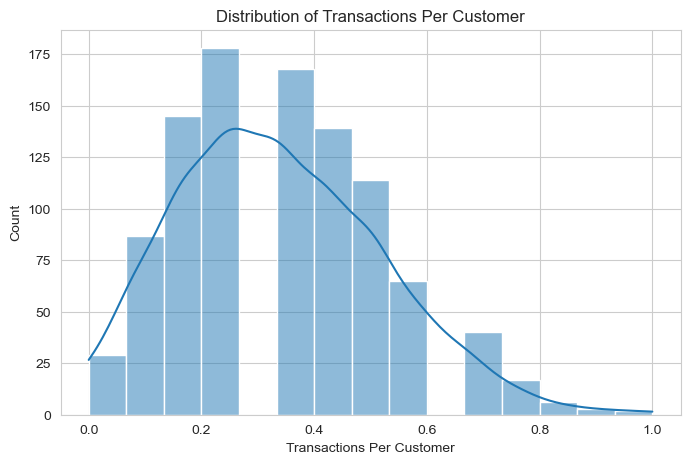

In [93]:
# **Distribution of Transactions per Customer**
# This histogram shows how many transactions each customer has made.
# - A high concentration at lower values suggests that most customers make only a few transactions.
# - A few customers with high transaction counts may indicate VIP users or power shoppers.
# - Identifying frequent vs. occasional users helps tailor **loyalty programs and marketing strategies**.


plt.figure(figsize=(8, 5))
sns.histplot(customer_features_normalized['Transactions_Per_Customer'], bins=15, kde=True)
plt.title("Distribution of Transactions Per Customer")
plt.xlabel("Transactions Per Customer")
plt.ylabel("Count")
plt.show()

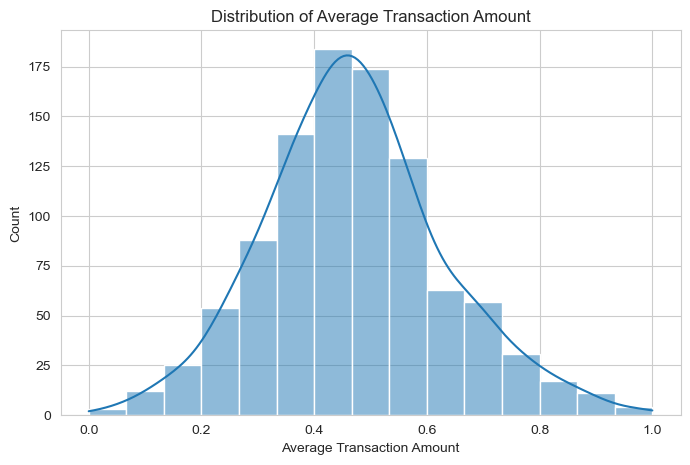

In [95]:
# **Distribution of Average Transaction Amount per Customer**
# This histogram displays the average transaction amount for each customer.
# - A peak at smaller amounts suggests that most customers make low-value transactions.
# - A long tail or right-skewed distribution indicates a few customers making large transactions.
# - This is useful for **identifying high-spending customers** and creating targeted promotions.

plt.figure(figsize=(8, 5))
sns.histplot(customer_features_normalized['Average_Transaction_Amount'], bins=15, kde=True)
plt.title("Distribution of Average Transaction Amount")
plt.xlabel("Average Transaction Amount")
plt.ylabel("Count")
plt.show()

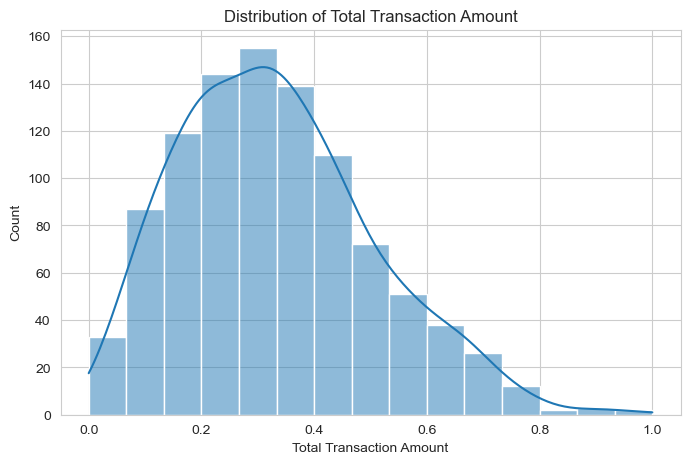

In [97]:
# **Distribution of Total Transaction Amount per Customer**
# This histogram shows how much each customer has spent in total.
# - A concentration at lower amounts means most customers have spent only a small amount.
# - A long right tail suggests that a small number of customers contribute a significant portion of total revenue.
# - This helps in **customer segmentation** to identify big spenders and casual users.

plt.figure(figsize=(8, 5))
sns.histplot(customer_features_normalized['Total_Transaction_Amount'], bins=15, kde=True)
plt.title("Distribution of Total Transaction Amount")
plt.xlabel("Total Transaction Amount")
plt.ylabel("Count")
plt.show()

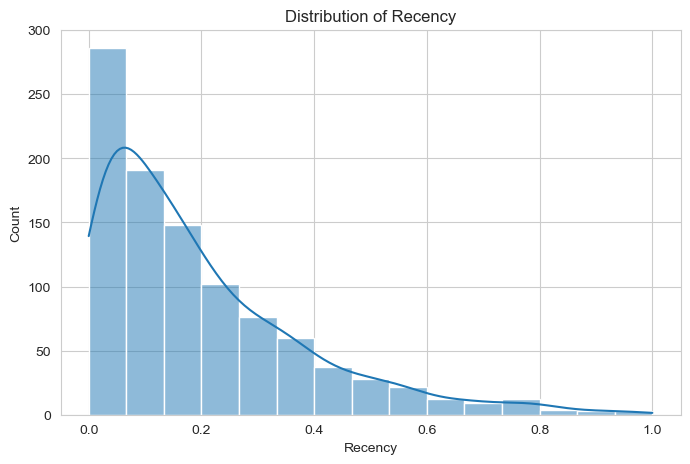

In [99]:
# **Distribution of Recency (Days Since Last Transaction)**
# This histogram shows how recently customers made their last transaction.
# - A peak at lower values means most customers have made recent transactions.
# - A peak at higher values suggests inactive customers who haven't transacted in a while.
# - Understanding recency helps in **designing re-engagement campaigns** to bring back inactive customers.

plt.figure(figsize=(8, 5))
sns.histplot(customer_features_normalized['Recency'], bins=15, kde=True)
plt.title("Distribution of Recency")
plt.xlabel("Recency")
plt.ylabel("Count")
plt.show()

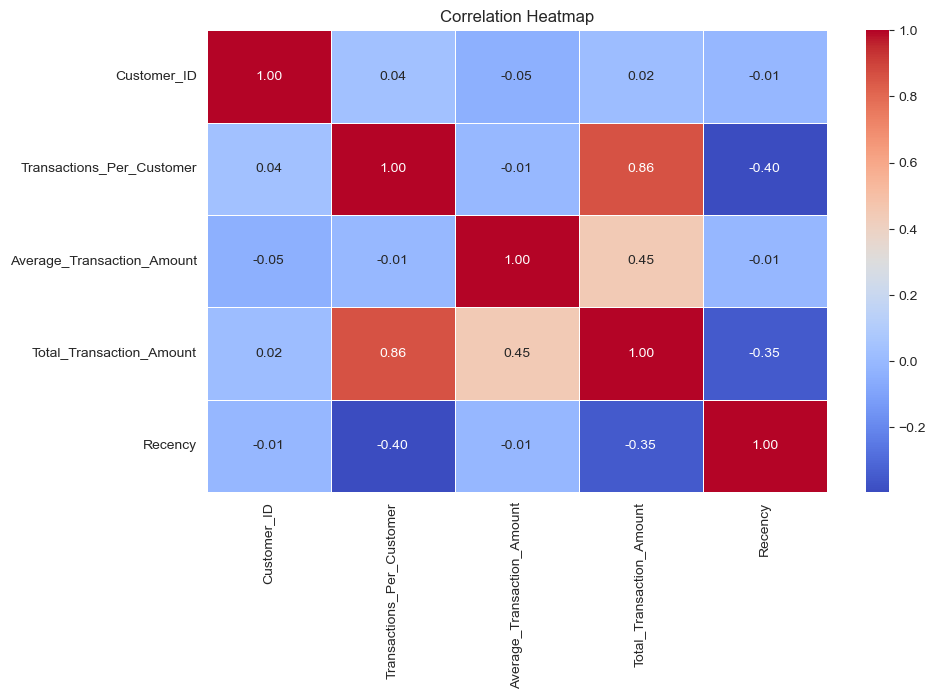

In [101]:
# **Correlation Heatmap**
# This heatmap visualizes relationships between numerical transaction-related features.
# - A strong correlation between **Total Transaction Amount and Number of Transactions** suggests frequent buyers spend more.
# - A weak correlation between **Recency and Total Spend** might indicate that recent users don't necessarily spend more.
# - These insights help in **customer retention and revenue growth strategies**.

plt.figure(figsize=(10, 6))
sns.heatmap(customer_features_normalized.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [103]:

customer_features_normalized.to_csv("final_transactions.csv", index=False)
prod_off.to_csv("final_prod_offering.csv", index=False)
transact.to_csv("final_transaction.csv", index=False)
